In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib


## 間引き描画

In [2]:
def downsample_indices(data: np.ndarray, width: int) -> np.ndarray:
    """
    ダウンサンプリングしたデータのインデックスを返します。返されるインデックスは、
    元のデータ配列の各スライス内の最大値と最小値を維持し、プロット時の視覚的な類似性を保つためのものです。
    データ配列の最初と最後の要素は常に返されるインデックスに含まれます。

    Parameters
    ----------
    data : np.ndarray shape=(N, n_samples)
        ダウンサンプリングするデータ配列

    width : int
        ダウンサンプリング後のデータ配列の幅

    Returns
    -------
    indices : np.ndarray
        ダウンサンプリング後のデータ配列のインデックス
    """
    # 入力データの次元をチェック
    if data.ndim > 2:
        raise ValueError(f"Expected data of 2 or less dimensions, but got: {data.ndim}")
    
    # データが2次元配列になるようにする
    data = np.atleast_2d(data)

    # 計算から最初と最後の要素を除くためのマスクを作成
    mask = np.zeros_like(data, dtype=bool)
    mask[:, 0] = mask[:, -1] = True
    masked_data = np.ma.array(data, mask=mask)

    num_samples = data.shape[-1]
    
    # データ配列の幅が要求された幅以下であれば、インデックスをそのまま返す
    if num_samples < 2 * width:
        return np.tile(np.arange(num_samples), (data.shape[0], 1))

    # ストライドと残りの部分を計算
    stride = num_samples // width
    residue = num_samples % stride

    # 最大と最小の計算を簡単にするためにマスクされたデータをリシェイプ
    reshaped_data = masked_data[:, :num_samples - residue].reshape([data.shape[0], -1, stride])

    # インデックス調整のためのゲタを計算
    geta = np.arange(reshaped_data.shape[1]) * stride

    # reshaped_dataの各スライス内の最大と最小のインデックスを計算
    max_indices = np.argmax(reshaped_data, axis=-1) + geta
    min_indices = np.argmin(reshaped_data, axis=-1) + geta

    # 残りの部分を処理
    if residue != 0:
        res_data = masked_data[:, -residue:]
        res_geta = np.array([geta[-1] + stride])
        max_res_indices = np.argmax(res_data, axis=-1)[:, np.newaxis] + res_geta
        min_res_indices = np.argmin(res_data, axis=-1)[:, np.newaxis] + res_geta

        # 残りの部分のインデックスを元の最大と最小のインデックスに結合
        max_indices = np.hstack((max_indices, max_res_indices))
        min_indices = np.hstack((min_indices, min_res_indices))

    # 最初と最後のインデックスが含まれるようにする
    edge_indices = np.tile([0, num_samples-1], (data.shape[0], 1))

    # インデックスを結合しソート
    indices = np.sort(np.hstack((edge_indices, max_indices, min_indices)))

    return indices

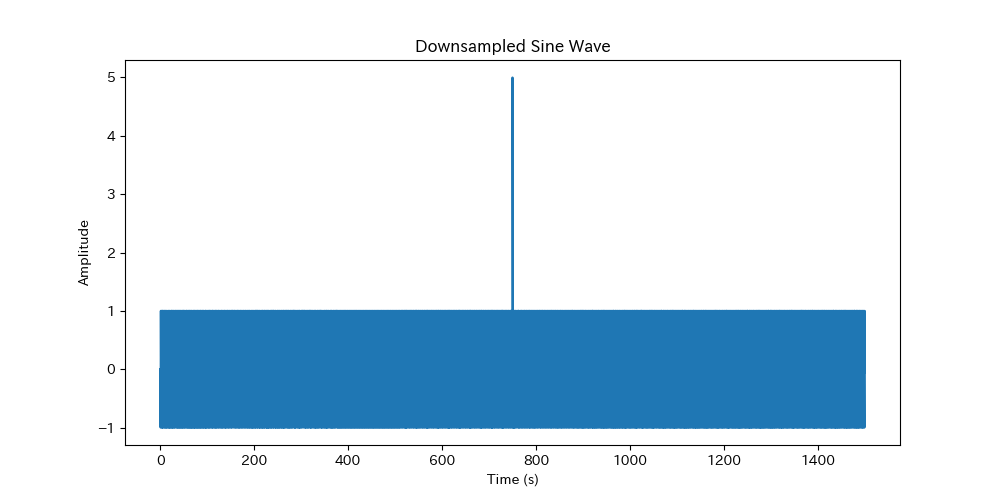

CPU times: user 638 ms, sys: 393 ms, total: 1.03 s
Wall time: 917 ms


In [3]:
%%time
# サンプルレート（Hz）
sample_rate = 44100

# サンプル生成のための時間配列（10分 = 600秒）
t = np.arange(0, 60*25, 1/sample_rate)

# シン波を生成（周波数440Hz）
freq = 440
audio_signal = np.sin(2 * np.pi * freq * t)
audio_signal[len(audio_signal)//2] = 5

# Figureを作成し、図のサイズとDPIを取得
fig, ax = plt.subplots(figsize=(10, 5))
dpi = fig.get_dpi()
fig_width_inches, _ = fig.get_size_inches()
fig_width_pixels = dpi * fig_width_inches

# ダウンサンプリングのためのインデックスを計算
downsampled_indices = downsample_indices(audio_signal, width=int(fig_width_pixels))[0]

# ダウンサンプリングしたデータを描画
plt.plot(t[downsampled_indices], audio_signal[downsampled_indices])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Downsampled Sine Wave')
plt.show()

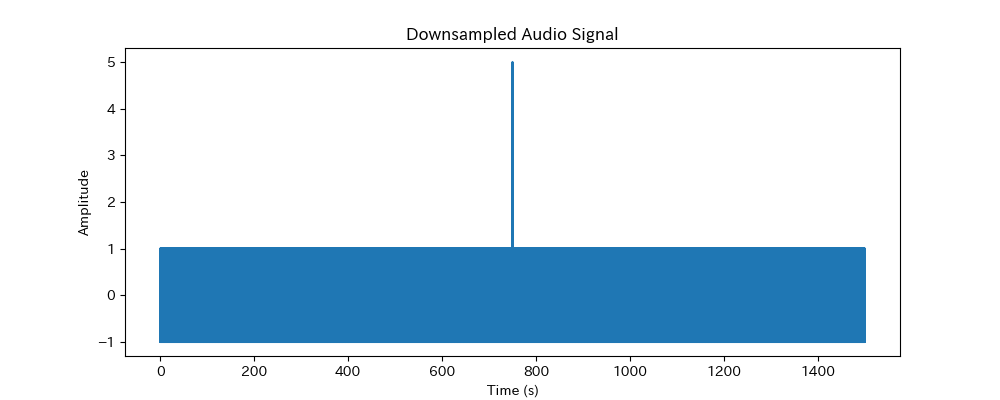

CPU times: user 2.51 s, sys: 489 ms, total: 3 s
Wall time: 2.84 s


In [4]:
%%time

# ダウンサンプルしたデータを描画
plt.figure(figsize=(10, 4))
plt.plot(t, audio_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Downsampled Audio Signal')
plt.show()

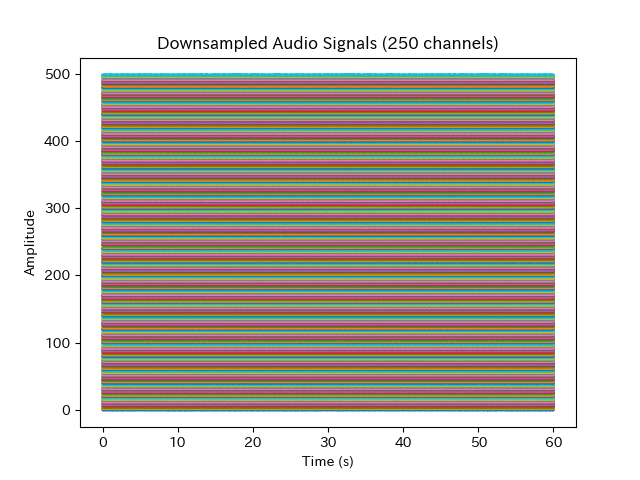

CPU times: user 6.38 s, sys: 3.48 s, total: 9.86 s
Wall time: 9.7 s


In [5]:
%%time
# LineCollectionに間引いたデータを登録して描画
from matplotlib.collections import LineCollection

# サンプルレート（Hz）
sample_rate = 44100

# サンプル生成のための時間配列（1分 = 60秒）
t = np.arange(0, 60, 1/sample_rate)

# 25チャンネルの音を生成
channels = 250
audio_signals = np.zeros((channels, len(t)))
for i in range(channels):
    freq = 440 + i  # 各チャンネルで異なる周波数
    audio_signals[i] = np.sin(2 * np.pi * freq * t) + i*2

# 図のサイズとDPIを取得
fig = plt.figure()
dpi = fig.get_dpi()
fig_width_inches, _ = fig.get_size_inches()
fig_width_pixels = dpi * fig_width_inches

# 各チャンネルをダウンサンプリングして描画
downsampled_indices = downsample_indices(audio_signals, width=int(fig_width_pixels))

for i, _index in enumerate(downsampled_indices):
    plt.plot(t[_index], audio_signals[i, _index])

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Downsampled Audio Signals (250 channels)')
plt.show()

In [6]:
%%time
# 図のサイズとDPIを取得
fig = plt.figure()
dpi = fig.get_dpi()
fig_width_inches, _ = fig.get_size_inches()
fig_width_pixels = dpi * fig_width_inches

plt.plot(t, audio_signals.T)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Downsampled Audio Signals (250 channels)')
plt.show()

: 

: 